In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
lyrics = []
for year in range(2000, 2005):
    df = pd.read_csv('/content/drive/MyDrive/Melon/Melon_{0}.csv'.format(year))
    
    #가사 데이터를 문장 단위로 나눠 저장
    for lyric in list(df.lyric.values):
        lyrics.extend(lyric.split('\n'))

In [ ]:
print("문장 개수:",len(lyrics))

문장 개수: 173140


In [ ]:
import re

not_hangul = re.compile('[^가-힣 +]')
def only_hangul(raw_sentence, not_hangul):
    # 특수문자 제거
    temp = re.sub('[^가-힣a-zA-Z0-9 ]', '', raw_sentence)

    # 한글 외의 문자를 포함하지 않는 문장만 전처리
    if not_hangul.search(temp) == None:
        # 문장 시작, 끝에 위치하는 띄어쓰기 삭제
        temp = re.sub('^ | $', '', temp)
        return temp

In [ ]:
# 전처리 가사 list로 저장
only_hangul_lyrics = []
for lyric in lyrics:
    temp = only_hangul(lyric, not_hangul)
    if temp == None or temp == '':
        continue
    only_hangul_lyrics.append(temp)
    
print("한글만 포함한 문장 개수:", len(only_hangul_lyrics))

한글만 포함한 문장 개수: 19034


In [ ]:
preprocessed_lyrics = []
for lyric in only_hangul_lyrics:
    sent1 = lyric
    sent2 = ''
    
    word_list = lyric.split(' ')
    if len(word_list) > 10:
        continue
    elif len(word_list) == 6 or len(word_list) == 7:
        sent1 = ' '.join(word_list[:2])
        sent2 = ' '.join(word_list[3:])
    elif len(word_list) == 8 or len(word_list) == 9:
        sent1 = ' '.join(word_list[:3])
        sent2 = ' '.join(word_list[4:])
    elif len(word_list) == 10:
        sent1 = ' '.join(word_list[:4])
        sent2 = ' '.join(word_list[5:])
    
    if sent2 == '':
        preprocessed_lyrics.append(sent1)
    else:
        preprocessed_lyrics.extend([sent1, sent2])

print("마디 길이 조정한 문장 개수:", len(preprocessed_lyrics))

마디 길이 조정한 문장 개수: 21368


(array([1.600e+01, 1.450e+02, 6.900e+02, 1.743e+03, 2.572e+03, 2.719e+03,
        3.681e+03, 4.699e+03, 5.559e+03, 5.154e+03, 5.001e+03, 4.257e+03,
        4.036e+03, 3.371e+03, 2.897e+03, 2.140e+03, 1.237e+03, 6.210e+02,
        1.680e+02, 2.000e+01, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 28 Patch objects>)

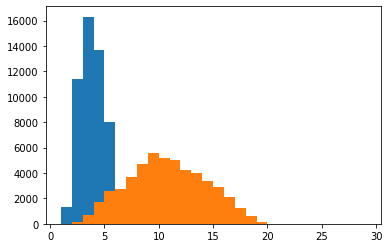

In [ ]:
import matplotlib.pyplot as plt


word_cnts = [len(lyric.split(' ')) for lyric in preprocessed_lyrics]
length = [len(i) for i in preprocessed_lyrics]

plt.hist(word_cnts, range(1, 10))
plt.hist(length, range(1, 30))
# 각 가사의 마디를 개행을 기준으로 나눴는데, 입력 형식에 따라 단어의 개수가 너무 다르다
# max(len) 에 맞춰 시퀀스를 형성할 경우 불필요한 메모리를 잡아먹으므로, 단어의 개수가 많은 가사는 두 개의 마디로 나눈다
# 단어 개수 분포를 봤을 때 3, 4개로 구성된 마디가 가장 많았고 5 개부터 급격히 감소했다.
# 단어가 6개인 마디 -> 3개, 3개
# 단어가 7개인 마디 -> 3개, 4개
# .. 8개 -> 4개, 4개
# .. 9개 -> 4개, 5개
# .. 10개 -> 5개, 5개
# 긴 마디를 두 마디로 분할해 데이터를 형성한다.

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 448 kB 43.4 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
#전처리된 가사에 대해 토큰화 진행
from konlpy.tag import Okt
okt = Okt()

tokenized_lyrics = []
for sentence in preprocessed_lyrics:
    tokenized_sentence = okt.morphs(sentence, stem=False) # 토큰화
    tokenized_lyrics.append(tokenized_sentence)

In [ ]:
# tokenizer로 단어 군집 형성
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(tokenized_lyrics)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기: %d'% vocab_size)
# 단어 집합의 크기가 매우 크다! 단어에 전처리를 해서 단어 개수를 줄이든, one-hot 벡터 변환 말고 다른 방식으로 학습을 하든 해야한다
# softmax와 cross entropy를 사용하는게 아니라 regression 방식으로 접근해서 label을 예측하자

단어 집합의 크기: 1092


In [ ]:
tokenized_lyrics = [list(sent) for sent in preprocessed_lyrics]

In [ ]:
# tokenizer로 단어 군집 형성
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(preprocessed_lyrics)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기: %d'% vocab_size)
# 단어 집합의 크기가 매우 크다! 단어에 전처리를 해서 단어 개수를 줄이든, one-hot 벡터 변환 말고 다른 방식으로 학습을 하든 해야한다
# softmax와 cross entropy를 사용하는게 아니라 regression 방식으로 접근해서 label을 예측하자

단어 집합의 크기: 16058


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16057
등장 빈도가 1번 이하인 희귀 단어의 수: 9026
단어 집합에서 희귀 단어의 비율: 56.21224388117332
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.950713824521129


In [ ]:
vocab_size_filter = total_cnt - rare_cnt
print('희귀 단어를 제외한 단어 집합의 크기:', vocab_size_filter)

희귀 단어를 제외한 단어 집합의 크기: 7031


In [ ]:
# tokenizer로 정수값을 부여 받은 단어들에 대한 dictionary 생성
# index_to_word[3] == '안녕'
index_to_word = {}
for key, value in tokenizer.word_index.items():
    index_to_word[value] = key

In [ ]:
# 정수 인코딩된 가사 리스트를 학습에 이용 가능한 시퀀스의 리스트로 변경
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(tokenized_lyrics)

sequences = list()

for sentence in tokenized_lyrics:
    # 문장을 각 단어의 정수값 리스트로 변환한다
    # 문장을 거꾸로 학습할 것이므로 단어 순서를 뒤집어 시퀀스를 생성한다
    encoded = tokenizer.texts_to_sequences([sentence])[0][::-1]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)


In [ ]:
tokenized_lyrics[1][::-1]

['곳', '머물다가는', '처럼', '구름']

In [ ]:
# 정수 인코딩된 가사 리스트를 학습에 이용 가능한 시퀀스의 리스트로 변경
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(preprocessed_lyrics)

sequences = list()

for sentence in preprocessed_lyrics:
    # 문장을 각 단어의 정수값 리스트로 변환한다
    # 문장을 거꾸로 학습할 것이므로 단어 순서를 뒤집어 시퀀스를 생성한다
    encoded = tokenizer.texts_to_sequences([sentence])[0][::-1]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)


In [ ]:
max_len = max(len(l) for l in sequences)
max_len

5

In [ ]:
# 패딩을 이용해 모든 시퀀스의 길이를 통일한다
max_len = max(len(l) for l in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)

# 임베딩 모델 학습 및 사전 임베딩 벡터 사용

In [ ]:
!pip install konlpy

In [ ]:
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Okt

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
w2v = Word2Vec(sentences = tokenized_lyrics, size = 200, window = 5, min_count = 5, workers = 4, sg = 0)
w2v.wv.save_word2vec_format('kor_w2v')
w2v_model = KeyedVectors.load_word2vec_format('kor_w2v')

In [ ]:
w2v_pretrained = Word2Vec.load('/content/drive/MyDrive/ko.bin')
w2v_pretrained.wv.save_word2vec_format('kor_w2v_pretrained')
pretrained_w2v_model = KeyedVectors.load_word2vec_format('kor_w2v_pretrained')

In [ ]:
w2v_model.vectors.shape

(5072, 100)

In [ ]:
def get_vector(word, word2vec_model):
    if word in word2vec_model:
        return word2vec_model[word]
    else: 
        return None

In [ ]:
embedding_matrix = np.zeros((vocab_size_filter, 200))
for word, index in index_to_word.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word, w2v_model)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [ ]:
embedding_dim = 200
hidden_units = 32

model = Sequential()
e = Embedding(vocab_size_filter, embedding_dim, weights=[embedding_matrix], input_length=max_len - 1, trainable=False)
model.add(e)
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size_filter, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, validation_split=0.2, epochs=100, verbose=2)

Epoch 1/100
4334/4334 - 49s - loss: 6.3918 - accuracy: 0.0293 - val_loss: 6.4271 - val_accuracy: 0.0256 - 49s/epoch - 11ms/step
Epoch 2/100
4334/4334 - 43s - loss: 6.3135 - accuracy: 0.0294 - val_loss: 6.4447 - val_accuracy: 0.0256 - 43s/epoch - 10ms/step
Epoch 3/100
4334/4334 - 42s - loss: 6.3103 - accuracy: 0.0293 - val_loss: 6.4475 - val_accuracy: 0.0256 - 42s/epoch - 10ms/step
Epoch 4/100
4334/4334 - 43s - loss: 6.3075 - accuracy: 0.0296 - val_loss: 6.4505 - val_accuracy: 0.0256 - 43s/epoch - 10ms/step
Epoch 5/100
4334/4334 - 43s - loss: 6.3060 - accuracy: 0.0295 - val_loss: 6.4569 - val_accuracy: 0.0256 - 43s/epoch - 10ms/step
Epoch 6/100
4334/4334 - 43s - loss: 6.3047 - accuracy: 0.0296 - val_loss: 6.4573 - val_accuracy: 0.0256 - 43s/epoch - 10ms/step
Epoch 7/100
4334/4334 - 43s - loss: 6.3035 - accuracy: 0.0295 - val_loss: 6.4579 - val_accuracy: 0.0256 - 43s/epoch - 10ms/step
Epoch 8/100
4334/4334 - 43s - loss: 6.3019 - accuracy: 0.0296 - val_loss: 6.4590 - val_accuracy: 0.0256 

In [ ]:
!pip install glove_python_binary

     |████████████████████████████████| 948 kB 7.1 MB/s 


In [ ]:
preprocessed_lyrics[:3]

['창가에 서면', '눈물처럼 떠오르는', '그대의 흰 손']

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(tokenized_data, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
print(glove.most_similar("그대"))

[('보나', 0.3049750351275811), ('고호란', 0.2737284563174261), ('되기', 0.2709175572083837), ('햇볕이', 0.2689548162476483)]


# 모델 학습

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 100
hidden_units = 32
drop_rate = 0.2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dropout(drop_rate))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
LR = 0.001

opt = Adam(learning_rate=LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(X, y, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/100
5187/5187 - 51s - loss: 4.2304 - accuracy: 0.2607 - val_loss: 3.8928 - val_accuracy: 0.3005 - 51s/epoch - 10ms/step
Epoch 2/100
5187/5187 - 48s - loss: 3.6510 - accuracy: 0.3157 - val_loss: 3.5901 - val_accuracy: 0.3305 - 48s/epoch - 9ms/step
Epoch 3/100
5187/5187 - 48s - loss: 3.4205 - accuracy: 0.3380 - val_loss: 3.4483 - val_accuracy: 0.3443 - 48s/epoch - 9ms/step
Epoch 4/100
5187/5187 - 48s - loss: 3.2896 - accuracy: 0.3516 - val_loss: 3.3621 - val_accuracy: 0.3595 - 48s/epoch - 9ms/step
Epoch 5/100
5187/5187 - 52s - loss: 3.1999 - accuracy: 0.3629 - val_loss: 3.3079 - val_accuracy: 0.3645 - 52s/epoch - 10ms/step
Epoch 6/100
5187/5187 - 48s - loss: 3.1332 - accuracy: 0.3703 - val_loss: 3.2605 - val_accuracy: 0.3710 - 48s/epoch - 9ms/step
Epoch 7/100
5187/5187 - 48s - loss: 3.0769 - accuracy: 0.3781 - val_loss: 3.2241 - val_accuracy: 0.3790 - 48s/epoch - 9ms/step
Epoch 8/100
5187/5187 - 52s - loss: 3.0273 - accuracy: 0.3828 - val_loss: 3.2022 - val_accuracy: 0.3826 - 52s

In [ ]:
model.save('/content/drive/MyDrive/model/model_2005_2010')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/model_2005_2010/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/model_2005_2010/assets


# 팝송 단어와 발음이 유사한 한글 단어로 가사 생성

In [ ]:
from tensorflow import keras 
model = keras.models.load_model('/content/drive/MyDrive/model/model_2000_2005')

In [ ]:
# 팝송 마디 끝 단어와 유사한 로마자 단어 불러오기

current_romans = []
for year in range(2010, 2011):
    with open('/content/drive/MyDrive/sample_words/{0}_rhyme_pairs.txt'.format(year), 'r') as f:
        current_romans.append([word[:-1].lower() for word in f.readlines()])


In [ ]:
len(current_romans)

10

In [ ]:
# (romanize, korean) dictionary 불러오기

import pickle
import numpy as np

# load data
with open('/content/drive/MyDrive/end_words.pickle', 'rb') as fr:
    end_words_loaded = pickle.load(fr)

roman_kor_pairs = [list(roman_kor_pair.values()) for roman_kor_pair in end_words_loaded]
roman_kor_pairs = np.array(roman_kor_pairs).T

In [ ]:
# 로마자 -> 한글

current_words = []
for song in current_romans:
    for word in song:
        try:
            current_words.append(roman_kor_pairs[1][list(roman_kor_pairs[0]).index(word)])
        except:
            current_words.append('pass')
#list(roman_kor_pairs[0]).index(current_words[0][0])

In [ ]:
# 입력할 단어에 대해 토큰화 진행
from konlpy.tag import Okt
okt = Okt()

tokenized_current_words = []
for word_list in current_words:
    tokenized_words = [okt.morphs(word, stem=False)[::-1] for word in word_list] # 토큰화
    tokenized_current_words.append(tokenized_words)
tokenized_current_words = [' '.join(word_list) for word_set in tokenized_current_words for word_list in word_set]

In [ ]:
def sentence_generation(model, tokenizer, current_word, n):
    init_word = current_word
    sentence = ''

    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len - 1, padding='pre')

        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items():
            if index == result:
                break
        
        current_word = current_word + ' ' + word
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [ ]:
max_len = 5

In [ ]:
' '.join(sentence_generation(model, tokenizer, '실어', 4).split(' ')[::-1])

'수 없는 너의 그 실어'

In [ ]:
generated_lyrics = []
for word in current_words:
    if word == 'pass':
        generated_lyrics.append('pass')
        continue
    generated = ' '.join(sentence_generation(model, tokenizer, word, 4).split(' ')[::-1])
    generated_lyrics.append(generated)

In [ ]:
generated_lyrics

['수 없는 너의 그 놓나',
 '수 없는 너의 그 지펴줘',
 '수 그걸 그걸 지켜보는 너',
 'pass',
 '사랑할 자격 갖춘 나 되어',
 '난 모두 가져가 내게 주었던',
 '그땐 우리 함께한 날들 생각나죠',
 '바랄게 다음번에 너 하나만 사랑할꺼야',
 '상관없어 하기엔 수단방법 가리지도 마',
 '아마 넌 그대는 나를 잊지마',
 '전활 이 감옥에서 나갈 때',
 '수 없는 너의 그 작은방',
 '너를 잡던 자꾸만 후회가 돼',
 '이유로 이렇게 날 외면하려 하나요',
 '어깨에 아픔만 믿어도 참고 그날을',
 '함께 알 수 주먹을 쥐고',
 '난 내겐 벅찬 행복 가득한데',
 '왜 내가 있으면 난 자꾸',
 '우리가 하지마 근사한 노랠 불러',
 '수 없는 너의 그 춰',
 '내게 안고싶은 어서 너를 만날',
 '니 안에서 나의 모든 게',
 '우리 맘 이맘 라라라라라라 라라라라라',
 '수 없는 너의 그 하지말어',
 '수 없는 너의 그 랄랄라라라라라라',
 '사랑할 자격 갖춘 나 되어',
 '수 없는 너의 그 널렸어',
 '수 없는 너의 그 춰',
 '내게 안고싶은 어서 너를 만날',
 '수 없는 너의 그 세월속에서',
 '우리 맘 이맘 라라라라라라 라라라라라',
 '수 없는 너의 그 하지말어',
 '상냥하고 너의 집앞에서 멀지 않은',
 '수 없는 너의 그 느껴버렸어',
 '마치 니 옷을 고르기가 어려워',
 '수 없는 너의 그 언젠지',
 '너를 이해하는 사람은 나 뿐야',
 '어떤 말이라도 내게 먼저 말해줘',
 '말해야 하는데 네 앞에 서면',
 '이젠 널 위해 남겨진 사랑하나',
 '상관없어 하기엔 수단방법 가리지도 마',
 '수 없는 너의 그 짧았지만',
 '수 없는 너의 그 있었고',
 '수 없는 너의 그 만났을땐',
 '수 없는 너의 그 안되죠',
 '수 없는 너의 그 카사블랑카',
 '일요일 두 손 흔들어 주었지',
 '이미 난 이미 얼어버릴 듯',
 '할 수 있다면 행복하게 살아줘',
 '당신과 나와 우리 둘이 함께',


In [ ]:
with open('/content/drive/MyDrive/generated/generated_2000_2005.txt', 'w') as f:
    for sent in generated_lyrics:
        f.write("%s\n" % sent)